In [15]:
import matplotlib.pyplot as plt
import matplotlib

import pandas as pd
import numpy as np
from typing import List
from typing import Union
from typing import Iterator
from typing import Optional
import re
import numpy as np
from functools import reduce
import ast
import json
from random import Random

import onnx
import tvm
from tvm.relay.frontend import onnx as ox
from tvm import relay
from tvm.autotvm.graph_tuner.utils import expr2graph

import torch
from torch.utils.data import DataLoader, Dataset, Sampler
from torch import nn
from torch.optim.lr_scheduler import _LRScheduler
from torch.optim import Adam, Optimizer
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


op_names = [
"torch.Linear", "core.Reshape", "core.ReplicatePad ", "core.ReLU", 
"core.ExpandLast1", "core.Sub", "core.NCHWConv2d", "core.Tril", "core.Mul", 
"core.Clip", "core.Atan", "core.Squeeze", "core.ReduceMax", "core.Or", 
"core.NearestInterp", "core.ExpandLast4", "core.Conv1d", "core.Min", 
"None", "core.Max", "Concat ", "core.Transpose", "core.Round", "core.ArgMax", 
"core.Where", "core.GELU", "core.AvgPool2d", "core.Ceil", "core.BatchNorm2d", 
"Constant", "core.LeakyReLU", "core.Sigmoid", "core.ReduceMean", "core.Add", 
"core.Neg", "core.Triu", "core.TrilinearInterp", "core.Floor", "core.ArgMin", 
"core.Div", "core.Xor", "core.Slice ", "core.BilinearInterp", "core.LinearInterp", 
"core.Abs", "core.Equal", "core.ConstPad ", "torch.Flatten", "core.And", "Input", 
"Cast ", "torch.TorchReduceSum", "core.Cos", "core.ExpandLast2", "core.Softmax", 
"core.Sin", "core.MaxPool2d", "core.BicubicInterp", "core.Less", "core.PReLU", 
"core.ExpandLast3", "core.ReduceMin", "core.ReflectPad ", "core.Tan", "core.Greater",
"torch.PTMatMul"
]


data_type_names = [
    "i64", "i32", "b", "i8", "f64", "i16", "Unknow", "f32", "f16", "u8"
]

vocab = {op:  idx for idx, op in enumerate(op_names)}
op_vocab = {op: idx for idx, op in enumerate(op_names)}

# Load the dataset from the JSON file
json_filename = 'train_3000_3000.json'
with open(json_filename, 'r') as jsonfile:
    loaded_dataset_dicts = json.load(jsonfile)


# Extract the lists from the loaded dataset
node_info_set = [item['node_info'] for item in loaded_dataset_dicts]
edge_info_set = [item['edge_info'] for item in loaded_dataset_dicts]
graph_info_set = [item['graph_info'] for item in loaded_dataset_dicts]
result_set = [item['result'] for item in loaded_dataset_dicts]
count_result = 0
count_true_result = 0
for result in result_set:
    if result == 1:
        count_true_result += 1
    count_result += 1
print("在",count_result,"中有",count_true_result,"个触发bug")

def onek_encoding_unk(value: int, choices: List):
    encoding = [0] * (len(choices) + 1)
    index = choices.index(value) if value in choices else -1
    encoding[index] = 1

    return encoding

def node_features(node_info:list):
    features = onek_encoding_unk(node_info[1], op_names)
    return features

def edge_features(edge_info:list):
    features = []
    for i in range(5):
        features.append(edge_info[2][i])
    tmp_list = onek_encoding_unk(edge_info[3], data_type_names)
    for i in range(len(tmp_list)):
        features.append(tmp_list[i])
    return features

def encode_graph_info(graph_info, op_vocab):
    # 对算子进行编码
    ops = graph_info[2]
    op_indices = [op_vocab.get(op, len(op_vocab)) for op in ops]

    # 创建onehot向量
    op_vector = [0] * (len(op_vocab) + 1)
    for idx in op_indices:
        op_vector[idx] = 1

    encoded_gragh_info = graph_info[:2] + op_vector 
    return encoded_gragh_info

def initialize_weights(model:nn.Module)->None:
    for param in model.parameters():
        if param.dim() == 1:
            nn.init.constant_(param, 0)
        else:
            nn.init.xavier_normal_(param)
            
for h in range(len(graph_info_set)):
    encoded_graph_info = encode_graph_info(graph_info_set[h], op_vocab)
    edge_info_hh = []
    for i in range(5):
        edge_info_hh.append(0)
    edge_info = edge_info_set[h]
    for i in range(len(edge_info)):
        for j in range(5):
            edge_info_hh[j] = edge_info[i][2][j] + edge_info_hh[j]
    
    graph_info = []
    for i in range(len(encoded_graph_info)):
        graph_info.append(encoded_graph_info[i])
    for i in range(len(edge_info_hh)):
        graph_info.append(edge_info_hh[i])
    graph_info_set[h] = graph_info

在 6000 中有 3000 个触发bug


In [16]:
len(graph_info_set[1])

74

In [17]:
random = Random()
sizes = [0.8, 0.1, 0.1]

indices = list(range(len(graph_info_set)))
random.shuffle(indices)

train_size = int(sizes[0] * len(graph_info_set))
train_val_size = int((sizes[0] + sizes[1]) * len(graph_info_set))

train_data = [graph_info_set[i] for i in indices[:train_size]]
val_data = [graph_info_set[i] for i in indices[train_size:train_val_size]]
test_data = [graph_info_set[i] for i in indices[train_val_size:]]

train_result = [result_set[i] for i in indices[:train_size]]
val_result = [result_set[i] for i in indices[train_size:train_val_size]]
test_result = [result_set[i] for i in indices[train_val_size:]]

train_data_tensor = torch.FloatTensor(train_data)
val_data_tensor = torch.FloatTensor(val_data)
test_data_tensor = torch.FloatTensor(test_data)

train_result_tensor = torch.LongTensor(train_result)
val_result_tensor = torch.LongTensor(val_result)
test_result_tensor = torch.LongTensor(test_result)

train_dataset = TensorDataset(train_data_tensor, train_result_tensor)
val_dataset = TensorDataset(val_data_tensor, val_result_tensor)
test_dataset = TensorDataset(test_data_tensor, test_result_tensor)

# 创建 DataLoader
batch_size = 64  # 可以根据需要调整批次大小
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)



In [18]:
from hmac import new


new_json_filename = './ort-v1.17.0-testdata_0_6/demo_test_data_info_0.json'
with open(new_json_filename, 'r') as val_jsonfile:
    val_loaded_dataset_dicts = json.load(val_jsonfile)

new_node_info_set = [item['node_info'] for item in val_loaded_dataset_dicts]
new_edge_info_set = [item['edge_info'] for item in val_loaded_dataset_dicts]
new_graph_info_set = [item['graph_info'] for item in val_loaded_dataset_dicts]
new_result_set = [item['result'] for item in val_loaded_dataset_dicts]

for h in range(len(new_graph_info_set)):
    encoded_graph_info = encode_graph_info(new_graph_info_set[h], op_vocab)
    edge_info_hh = []
    for i in range(5):
        edge_info_hh.append(0)
    edge_info = new_edge_info_set[h]
    for i in range(len(edge_info)):
        for j in range(5):
            edge_info_hh[j] = edge_info[i][2][j] + edge_info_hh[j]
    
    graph_info = []
    for i in range(len(encoded_graph_info)):
        graph_info.append(encoded_graph_info[i])
    for i in range(len(edge_info_hh)):
        graph_info.append(edge_info_hh[i])
    new_graph_info_set[h] = graph_info


new_graph_info_tensor = torch.FloatTensor(new_graph_info_set)
new_result_tensor = torch.LongTensor(new_result_set)


new_dataset = TensorDataset(new_graph_info_tensor, new_result_tensor)


batch_size = 64  # 可以根据需要调整批次大小
new_data_loader = DataLoader(new_dataset, batch_size=batch_size, shuffle=True)


In [19]:
import torch
import torch.nn as nn

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(74, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.fc4 = nn.Linear(256, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        initialize_weights_let(self)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        return torch.sigmoid(x)  # 添加sigmoid激活函数，输出概率值

def initialize_weights_let(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm1d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)


In [20]:
def train(model, data_loader, optimizer, criterion, num_epochs=1):
    model.train()  # 设置模型为训练模式
    for epoch in range(1):
        total_loss = 0
        for inputs, labels in data_loader:
            optimizer.zero_grad()  # 清空之前的梯度
            outputs = model(inputs)  # 得到模型的输出
            loss = criterion(outputs.squeeze(1), labels.float())  # 计算损失
            loss.backward()  # 反向传播
            optimizer.step()  # 更新参数
            total_loss += loss.item()

        return total_loss / len(data_loader)

def evaluate(model, data_loader, threshold=0.6):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    correct_predictions_positives = 0
    total_samples = 0
    total_positives = 0
    predicted_positives = 0
    with torch.no_grad():
        for batch in data_loader:
            inputs, targets = batch
            outputs = model(inputs).squeeze(1)  # 确保输出是1D tensor
            targets = targets.float()  # 确保标签是float类型，适用于binary_cross_entropy
            loss = F.binary_cross_entropy(outputs, targets)
            total_loss += loss.item()
            predictions = (outputs >= threshold).long()
            correct_predictions += (predictions == targets.long()).sum().item()
            correct_predictions_positives += ((predictions == 1) & (targets == 1)).sum().item()
            total_samples += targets.size(0)
            total_positives += (targets == 1).sum().item()
            predicted_positives += (predictions == 1).sum().item()

    overall_accuracy = correct_predictions / total_samples * 100 if total_samples > 0 else 0
    positive_accuracy = correct_predictions_positives / total_positives * 100 if total_positives > 0 else 0
    return total_loss / len(data_loader), overall_accuracy, positive_accuracy, total_positives, predicted_positives

In [21]:
model = SimpleNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCELoss()  # 二元交叉熵损失
model

SimpleNN(
  (fc1): Linear(in_features=74, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [22]:
class TrainArgs:
    no_cuda = False
    gpu = 0
    num_workers = 16
    batch_size = 16
    dataset_type = 'classification'
    task_names = []
    num_tasks = 1
    seed = 0
    hidden_size = 400
    bias = False
    depth = 3
    dropout = 0.3
    undirected = False
    aggregation = 'norm'
    aggregation_norm = 200
    cuda = True
    ffn_num_layers = 3
    ffn_hidden_size = 300
    init_lr = 1e-4
    max_lr = 1e-3
    final_lr = 1e-4
    num_lrs = 1
    warmup_epochs = 2.0
    epochs = 100

    @property
    def device(self) -> torch.device:
        """The :code:`torch.device` on which to load and process data and models."""
        if not self.cuda:
            return torch.device('cpu')

        return torch.device('cuda', self.gpu)

    @device.setter
    def device(self, device: torch.device) -> None:
        self.cuda = device.type == 'cuda'
        self.gpu = device.index

    @property
    def cuda(self) -> bool:
        """Whether to use CUDA (i.e., GPUs) or not."""
        return not self.no_cuda and torch.cuda.is_available()

    @cuda.setter
    def cuda(self, cuda: bool) -> None:
        self.no_cuda = not cuda
        
args = TrainArgs()

def main():
    best_val_loss = float('inf')
    best_val_accuracy = 0
    best_model_state = model.state_dict()

    for epoch in range(100):
        train_loss = train(model, train_data_loader, optimizer, criterion, num_epochs=1)
        val_loss, val_accuracy, val_positive_accuracy, total_positives, predicted_positives = evaluate(model, val_data_loader)
        print(f'Epoch {epoch+1}/{args.epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, '
              f'Positive Accuracy: {val_positive_accuracy:.2f}%, Total Positives: {total_positives}, Predicted Positives: {predicted_positives}')

        # Check if the current model is better than the best model so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            # Save the best model state
            torch.save(best_model_state, 'let_best_model.pth')

    # Load the best model state
    model.load_state_dict(best_model_state)

    # Evaluate on the test set
    test_loss, test_accuracy, test_positive_accuracy, test_total_positives, test_predicted_positives = evaluate(model, test_data_loader)
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, '
          f'Test Positive Accuracy: {test_positive_accuracy:.2f}%, Test Total Positives: {test_total_positives}, Test Predicted Positives: {test_predicted_positives}')

In [23]:
main()

Epoch 1/100, Train Loss: 0.7949, Val Loss: 0.7179, Val Accuracy: 50.83%, Positive Accuracy: 99.34%, Total Positives: 305, Predicted Positives: 596
Epoch 2/100, Train Loss: 0.7159, Val Loss: 0.7106, Val Accuracy: 51.00%, Positive Accuracy: 97.05%, Total Positives: 305, Predicted Positives: 581
Epoch 3/100, Train Loss: 0.7175, Val Loss: 0.7425, Val Accuracy: 50.50%, Positive Accuracy: 98.36%, Total Positives: 305, Predicted Positives: 592
Epoch 4/100, Train Loss: 0.6981, Val Loss: 0.7388, Val Accuracy: 50.50%, Positive Accuracy: 98.03%, Total Positives: 305, Predicted Positives: 590
Epoch 5/100, Train Loss: 0.6919, Val Loss: 0.7180, Val Accuracy: 51.17%, Positive Accuracy: 97.38%, Total Positives: 305, Predicted Positives: 582
Epoch 6/100, Train Loss: 0.6719, Val Loss: 0.7383, Val Accuracy: 51.17%, Positive Accuracy: 98.03%, Total Positives: 305, Predicted Positives: 586
Epoch 7/100, Train Loss: 0.6856, Val Loss: 0.7097, Val Accuracy: 51.67%, Positive Accuracy: 96.07%, Total Positives: 3

In [24]:
# 评估模型
total_loss, overall_accuracy, positive_accuracy, total_positives, predicted_positives = evaluate(model, new_data_loader, threshold=0.3)
print(f'Test Loss: {total_loss}')
print(f'Overall Accuracy: {overall_accuracy}%')
print(f'Positive Accuracy: {positive_accuracy}%')
print(f'Total Positives: {total_positives}')
print(f'Predicted Positives: {predicted_positives}')


Test Loss: 1.2352061310564946
Overall Accuracy: 0.006%
Positive Accuracy: 100.0%
Total Positives: 6
Predicted Positives: 100000


In [25]:
def predict(model, data_loader):
    """
    预测测试用例触发 bug 的概率，并按照概率值降序排序。

    参数:
        model: 已经训练好的模型。
        data_loader: DataLoader 实例，用于加载测试数据集。

    返回:
        bug_indices: 按照触发 bug 概率降序排序的测试用例索引序列。
    """
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in data_loader:
            inputs, targets = batch
            output = model(inputs)
            predictions.extend(output.squeeze(1).tolist())

    # 将预测结果和对应的测试用例组合成元组列表
    bug_probabilities = list(enumerate(predictions))

    # 按照触发 bug 概率降序排序
    bug_probabilities.sort(key=lambda x: x[1], reverse=True)

    # 提取排序后的测试用例索引
    bug_indices = [idx for idx, _ in bug_probabilities]

    return bug_indices, predictions




In [26]:
RO_detect_bug_time_list_total = []
LET_detect_bug_time_list_total = []
for iteration_count in range(1):
    # 预测
    json_filename = './ort-v1.17.0-testdata_0_7/demo_test_data_info_{}.json'.format(iteration_count)
    with open(json_filename, 'r') as jsonfile:
        demo_test_data_info = json.load(jsonfile)
    json_filename = './ort-v1.17.0-testdata_0_7/demo_test_time_info_{}.json'.format(iteration_count)
    with open(json_filename, 'r') as jsonfile:
        demo_test_time_info = json.load(jsonfile)
    new_node_info_set = [item['node_info'] for item in demo_test_data_info]
    new_edge_info_set = [item['edge_info'] for item in demo_test_data_info]
    new_graph_info_set = [item['graph_info'] for item in demo_test_data_info]
    new_result_set = [item['result'] for item in demo_test_data_info]

    for h in range(len(new_graph_info_set)):
        encoded_graph_info = encode_graph_info(new_graph_info_set[h], op_vocab)
        edge_info_hh = []
        for i in range(5):
            edge_info_hh.append(0)
        edge_info = new_edge_info_set[h]
        for i in range(len(edge_info)):
            for j in range(5):
                edge_info_hh[j] = edge_info[i][2][j] + edge_info_hh[j]
        
        graph_info = []
        for i in range(len(encoded_graph_info)):
            graph_info.append(encoded_graph_info[i])
        for i in range(len(edge_info_hh)):
            graph_info.append(edge_info_hh[i])
        new_graph_info_set[h] = graph_info

    new_graph_info_tensor = torch.FloatTensor(new_graph_info_set)
    new_result_tensor = torch.LongTensor(new_result_set)
    new_dataset = TensorDataset(new_graph_info_tensor, new_result_tensor)
    batch_size = 64  # 可以根据需要调整批次大小
    new_data_loader = DataLoader(new_dataset, batch_size=batch_size, shuffle=False)

    new_gen_time_set = [item['tgen']+item['tmat'] for item in demo_test_time_info]
    new_fetch_time_set = [item['tfetch'] for item in demo_test_time_info]
    new_exec_time_set = [item['texec'] for item in demo_test_time_info]
    new_loss, new_accuracy, new_positive_accuracy, new_total_positives, new_predicted_positives = evaluate(model, new_data_loader)
    print(f'Test Loss: {new_loss:.4f}, Test Accuracy: {new_accuracy:.2f}%, '
              f'Test Positive Accuracy: {new_positive_accuracy:.2f}%, Test Total Positives: {new_total_positives}, Test Predicted Positives: {new_predicted_positives}')
    bug_indices, _ = predict(model, new_data_loader)

    # Random Order就是按照demo_test_data_loader中的顺序来运行
    # LET用bug_indices中的顺序运行
    # 从demo_test_time_info中获取运行时间
    
    LET_detect_bug_time_list = []
    RO_detect_bug_time_list = []
    LET_total_exec_time = 0
    RO_total_exec_time = 0

    # LET方法的时间统计
    for i in bug_indices:
        LET_total_exec_time = new_exec_time_set[i] + LET_total_exec_time
        if new_result_set[i] != 0:
            LET_detect_bug_time_list.append(LET_total_exec_time)
    LET_detect_bug_time_list_total.append(LET_detect_bug_time_list)

    # RO方法的时间统计
    for i in range(len(new_exec_time_set)):
        RO_total_exec_time = new_exec_time_set[i] + RO_total_exec_time
        if new_result_set[i] != 0:
            RO_detect_bug_time_list.append(RO_total_exec_time)
    RO_detect_bug_time_list_total.append(RO_detect_bug_time_list)


Test Loss: 1.2354, Test Accuracy: 4.55%, Test Positive Accuracy: 100.00%, Test Total Positives: 7, Test Predicted Positives: 85916


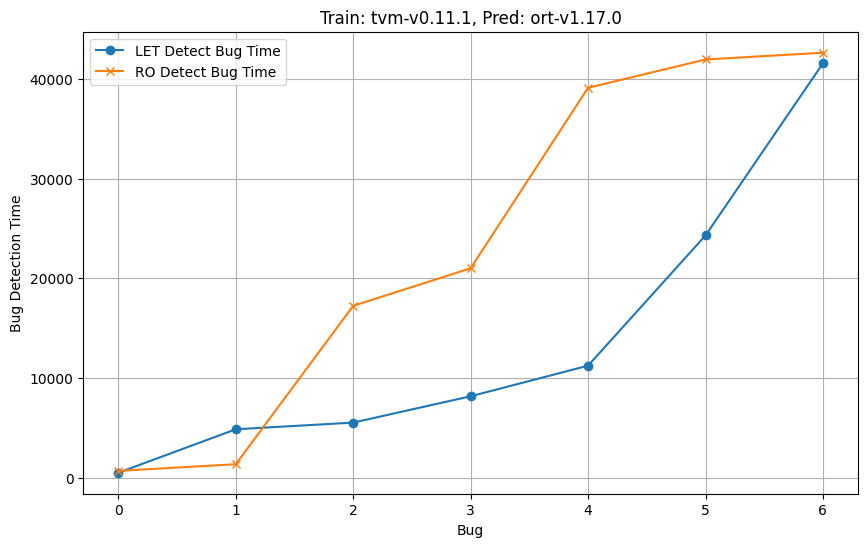

In [27]:
average_LET_detect_bug_time = []
average_RO_detect_bug_time = []
for i in range(len(LET_detect_bug_time_list)):
    average_LET_detect_bug_time.append(0)
    average_RO_detect_bug_time.append(0)
for i in range(len(LET_detect_bug_time_list)):
    for j in range(len(LET_detect_bug_time_list_total)):
        average_LET_detect_bug_time[i] += LET_detect_bug_time_list_total[j][i]
        average_RO_detect_bug_time[i] += RO_detect_bug_time_list_total[j][i]
for i in range(len(LET_detect_bug_time_list)):
    average_LET_detect_bug_time[i] = average_LET_detect_bug_time[i] / len(LET_detect_bug_time_list_total)
    average_RO_detect_bug_time[i] = average_RO_detect_bug_time[i] / len(LET_detect_bug_time_list_total)


# 创建图表
plt.figure(figsize=(10, 6))

# 绘制 LET_detect_bug_time_list
plt.plot(average_LET_detect_bug_time, label='LET Detect Bug Time', marker='o')

# 绘制 RO_detect_bug_time_list
plt.plot(average_RO_detect_bug_time, label='RO Detect Bug Time', marker='x')

# 添加标题和标签
plt.title('Train: tvm-v0.11.1, Pred: ort-v1.17.0')
plt.xlabel('Bug')
plt.ylabel('Bug Detection Time')

# 添加图例
plt.legend()

# 显示图表
plt.grid(True)
plt.show()

In [28]:
import pickle
with open("let-ort-v1.17.0-testdata_0_7.pkl", 'wb') as file:
    pickle.dump(average_LET_detect_bug_time, file)